##### 2020 George Mihaila.

# Find new sentiments in text data


<td>
    <a target="_blank" href="https://jupyterlab.hpc.unt.edu/"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run on Talon</a>
</td>
<td>
  <a target="_blank" href="https://github.com/gmihaila/unt_hpc/blob/master/workshops/march_3_2019/README.md"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</br>

The main purpose of this tutorial is to target a particular Natural Language Processing (NLP) problem, in this case Sentiment Analysis, and use GPUs for great speedup.

Walkthoughs:

### Dataset used:
* [IMDB moview reviews sentiment dataset](http://ai.stanford.edu/%7Eamaas/data/sentiment/): This is a dataset for binary sentiment classification containing a set of **25,000** highly polar movie reviews for training, and **25,000** for testing. For this tutorial we will combine the train and test data for a total of **50,000 movies reviews** text data and their negative/positive labels.


### Content:

 * Train custom word embeddings using a small Neural Network.
 * Use Lime to explain model predictions.
 * Use the embedding model to create review embeddings.
 * Use GPU to perform kmeans clustering on all 50,000 movies reviews.
 * Find the best splitting K using the Elbow method and Silhouette score.
 * Use k=2 on kmeans and plot the sentiments on both predicted clusters and true labels.
 * Observe the overlap between the predcited labels and true labels and asociate labels to clusters. Visualize the clusters.
 * Try to find a third sentiment using k=3. Observe the overlab between predicted labels and true labels. Visualize the clusters.
 * Repeat previous experiments using different k and observe predicitons overlp with true labels. Visualize the clusters.
 * Visualize samples of text that are predicted with various sentiments.

## NLP - Fine-grained Sentiment Analysis

For most cases sentiment classifiers are used in binary classification (just positive or negative sentiment). That is because fine-grained sentiment classification is a significantly more challenging task! 

The typical breakdown of fine-grained sentiment uses five discrete classes, as shown below. As one might imagine, models very easily err on either side of the strong/weak sentiment intensities thanks to the wonderful subtleties of human language.

![alt text](https://miro.medium.com/max/705/1*ug8kyqUlnqEuo3LhHfNypg.png)

Binary class labels may be sufficient for studying large-scale positive/negative sentiment trends in text data such as Tweets, product reviews or customer feedback, but they do have their limitations. 

When performing information extraction with comparative expressions, for example: 
 * “This OnePlus model X is so much better than Samsung model X.” 
  * a fine-grained analysis can provide more precise results to an automated system that prioritizes addressing customer complaints. 

 * “The location was truly disgusting ... but the people there were glorious.” 
  * dual-polarity sentences can confuse binary sentiment classifiers, leading to incorrect class predictions.

[source](https://towardsdatascience.com/fine-grained-sentiment-analysis-in-python-part-1-2697bb111ed4)



## Installs

* [Sentence-Transformers](https://colab.research.google.com/drive/1rY7Ln6rEE1pOlfSHCYOVaqt8OvDO35J0#forceEdit=true&sandboxMode=true&scrollTo=scfLT2i0MLyD): wrapper around Hugging Face [transformers](https://github.com/huggingface/transformers) library and built for document embedding using state of the art language models like BERT or XLNET.

## Dataset

* **data/imdb_reviews_subwords8k_text_features.pickle** contains the text encoder - decoder binary file of type `info.features['text'].encoder` from `tensorflow_datasets`
   
* **data/imdb_reviews_50k.csv** contains all movie revies and their sentiments:
  
| review                                            	| sentiment 	|
|---------------------------------------------------	|-----------	|
| This was an absolutely terrible movie. Don't b... 	| 0         	|
| I have been known to fall asleep during films,... 	| 0         	|

## Imports

In [1]:
import os
# avoid using GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = ''
import torch
## Load TF 2.0
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import seaborn as sns
import pandas as pd
from nltk.corpus import stopwords 
import nltk
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from lime.lime_text import LimeTextExplainer
import pickle

# stop words
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

# data frame display setup
pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

ID_SENTIMENT = {0:'Negative',
                1:'Positive'}

[nltk_data] Downloading package stopwords to /home/gm0234/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/gm0234/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
/cm/shared/utils/PYTHON/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


## Functions

In [2]:
def plt_history(history_dict, 
                acc_key='accuracy', val_acc_key='val_accuracy', 
                loss_key='loss', val_loss_key='val_loss'):
  acc = history_dict[acc_key]
  val_acc = history_dict[val_acc_key]
  loss = history_dict[loss_key]
  val_loss = history_dict[val_loss_key]
  epochs = range(1, len(acc) + 1)
  plt.subplot(1, 2, 1)
  # "bo" is for "blue dot"
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)


  plt.subplot(1, 2, 2)
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  plt.grid()
  plt.tight_layout()
  plt.xticks(epochs)
  fig = plt.gcf()
  fig.set_size_inches(15, 5)
  plt.show()
  return


def predictions_overlap(model_predicitons, true_predicitons, label_decoder):
  """Find overlap between predicted labels that aren't associated with any actual classes
  and actual classes.

  """
  labels = list(set(model_predicitons))
  print("Found labels: %s\n" % labels)
  ## dicitonary with predicitons counts clusters
  predictions = {label:[] for label in labels}
  for true_label, pred_label in zip(true_predicitons, model_predicitons):
    predictions[pred_label].append(true_label)
  # data frame
  matching_df = pd.DataFrame()
  matching_df['labels'] = labels
  matching_df['cluster_match'] = ["  ".join([str(label_decoder[cluster])+":"+str(count) for cluster, count in Counter(predictions[label]).most_common()]) for label in labels]
  return matching_df


def clusters_words_plot(texts, labels, n_sentiments, pos_tag, top_clip=0, low_clip=20, stop_words=None, magnify=2):
  # low_clip and top_clip are clips of the most frequent words to show
  # pos_tag in ['VB', 'NN']
  labels_texts = {n:[] for n in range(n_sentiments)}
  for text, label in zip(texts, labels):
    labels_texts[label].append(text)
  for sentiment in range(n_sentiments):
    # fit tokenizer on texts
    tokenizer = tf.keras.preprocessing.text.Tokenizer()
    tokenizer.fit_on_texts(texts=labels_texts[sentiment])
    top_words = list(tokenizer.word_index.keys())
    if pos_tag is not None: 
      top_words = nltk.pos_tag(tokens=top_words)
      top_words = [val[0] for val in top_words if val[1]==pos_tag]
    if stop_words is not None: top_words=[word for word in top_words if word not in stop_words]
    # temporary Data Frame
    tmp_df = pd.DataFrame()
    tmp_df['words'] = top_words[top_clip:low_clip]
    tmp_df['count'] = [tokenizer.word_counts[word] for word in top_words[top_clip:low_clip]]
    # plot
    ax = sns.barplot(x='words', y='count', data=tmp_df)
    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='x-large')
    fig = plt.gcf()
    ax.set_title('Words Counts Sentimen %s'%sentiment)
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
  return


def show_samples(target_predicitons_class, texts, predicitons, trues, trues_id_sentiment,
                 predictions_id_sentiment, n_samples):
  samples_texts = []
  samples_labels = []

  while len(samples_texts) < n_samples:
    pick = np.random.randint(low=0, high=(len(trues)-1))
    if predicitons[pick] == target_predicitons_class:
      samples_texts.append(texts[pick])
      samples_labels.append(trues[pick])

  samples_df = pd.DataFrame()
  samples_df['Text'] = samples_texts
  samples_df['Label Sentiment'] = [trues_id_sentiment[label] for label in samples_labels]
  samples_df['Prediction Sentiment'] = [predictions_id_sentiment[target_predicitons_class] for _ in samples_labels]
  return samples_df

# Dataset Prep

## Read CSV

In [3]:
# get text_features from binary
with open('../data/imdb_reviews_subwords8k_text_features.pickle', 'rb') as handle:
    text_features = pickle.load(handle)
print('Vocabulary size:', text_features.vocab_size)

# read reviews from csv file
review_sentiments_df = pd.read_csv('../data/imdb_reviews_50k.csv')
# get reviews and sentiments
reviews_texts, reviews_sentiments = review_sentiments_df['review'].values, review_sentiments_df['sentiment'].values
# print first 2 examples
review_sentiments_df.head(n=2)

Vocabulary size: 8185


review  \
0  This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.   
1  I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of what was causing them or why. I admit, I may have missed part of the film, but i watched the majority of it and everything just seemed to happen of its own accord without any real concern for anything else. I cant recommend this film at all.                                                                                               

   sentiment  
0  0          
1  0

## Encode Text

In [4]:
# encode_review
reviews_encodings = [text_features.encode(review) for review in reviews_texts]
# get max length of review
max_review_length = max([len(encoding) for encoding in reviews_encodings])
# global variable
MAX_LEN = max_review_length # 500
# pad all reviews to max length
reviews_encodings = tf.keras.preprocessing.sequence.pad_sequences(sequences=reviews_encodings, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post', value=0.0)

print('reviews_encodings shape:', reviews_encodings.shape)

reviews_encodings shape: (50000, 3944)


# Simple Neural Network

## Config

In [5]:
EMBEDDING_SIZE = 16 #300 #100
BUFFER_SIZE = 1000
BATCH = 500
EPOCHS = 20

## Prep Data

In [6]:
# split train 80% - test 20% 
encodings_train, encodings_test, sentiments_train, sentiments_test = train_test_split(reviews_encodings, reviews_sentiments, train_size=0.8, shuffle=True, random_state=20)
# split train into validation 10%
encodings_train, encodings_valid, sentiments_train, sentiments_valid = train_test_split(encodings_train, sentiments_train, train_size=0.9, shuffle=True, random_state=20)
# shape (number of examples X sequence length)
print('Train shape:     ', encodings_train.shape)
print('Validation shape:', encodings_valid.shape)
print('Test shape:      ', encodings_test.shape)

Train shape:      (36000, 3944)
Validation shape: (4000, 3944)
Test shape:       (10000, 3944)


## Data Generators

In [7]:
# train generator
train_genrator = tf.data.Dataset.from_tensor_slices((encodings_train, sentiments_train))
# batching generator and shuffle
train_batches = train_genrator.batch(BATCH).shuffle(BUFFER_SIZE)
# increase speed by overlaping the preprocessing and model execution of a training step
train_batches = train_batches.prefetch(tf.data.experimental.AUTOTUNE)

# validation generator
valid_genrator = tf.data.Dataset.from_tensor_slices((encodings_valid, sentiments_valid))
# batching generator
valid_batches = valid_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
valid_genrator = valid_genrator.prefetch(tf.data.experimental.AUTOTUNE)

## Modeling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
average (GlobalAveragePoolin (None, 16)                0         
_________________________________________________________________
hidden (Dense)               (None, 16)                272       
_________________________________________________________________
prediction (Dense)           (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________
Train for 72 steps, validate for 8 steps
Epoch 1/20
72/72 [==============================] - 11s 155ms/step - loss: 0.6930 - accuracy: 0.5113 - val_loss: 0.6925 - val_accuracy: 0.6375
Epoch 2/20
72/72 [==============================] - 11s 150ms/st

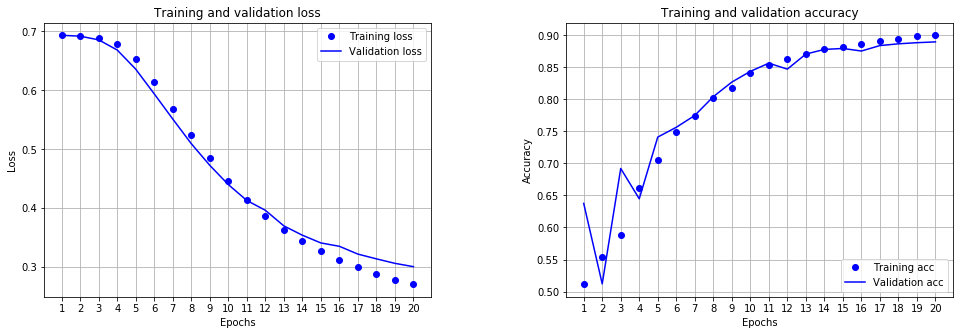

In [8]:
# build model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(text_features.vocab_size, EMBEDDING_SIZE, name='embedding'))
model.add(tf.keras.layers.GlobalAveragePooling1D(name='average'))
model.add(tf.keras.layers.Dense(16, activation='elu', name='hidden'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='prediction'))
# print overview
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# train and keep track of history
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=valid_batches,
                    verbose=1)
# plot training curves
plt_history(history_dict=history.history)

## Evaluations

In [9]:
# get model predicitons
sentiments_predicitons = model.predict_classes(encodings_test)
# print evaluation report
print(classification_report(y_true=sentiments_test, y_pred=sentiments_predicitons))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4948
           1       0.88      0.89      0.88      5052

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



## Explain Model

In [10]:
example_index = np.random.randint(0, len(sentiments_test)-1)

review_text = text_features.decode(encodings_test[example_index])
review_sentiment = sentiments_test[example_index]
review_prediction = int(sentiments_predicitons[example_index])

print('Review Sample:\n',review_text)
print('Sentiment:  {}'.format(ID_SENTIMENT[review_sentiment]))
print('Prediciton: {}\n'.format(ID_SENTIMENT[review_prediction]))

# explain model prediciton
def classifier_dn(strings):
  '''Takes as input list of stirngs.
  Outputs numpy array of porbabilities
  '''
  probab = []
  for string in strings:
    encoding = text_features.encode(string)
    encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                             maxlen=MAX_LEN, 
                                                             padding='post', 
                                                             truncating='post', 
                                                             dtype='float32')
    preds = model(encoding)[0][0]
    probab.append([(1-preds), preds])
  return np.array(probab)
# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(review_text,  classifier_dn, num_features=MAX_LEN)
# output to cell
exp.show_in_notebook(text=True)

Review Sample:
 I LOVE this movie....one of my all-time favorites!!! This was the first big screen movie my mom took me to see when I was 9. I highly recommend it to every african-american. This story is about love, trust, challenges, and everyday life of a black family. All the actors worked well together. I wish it was on video, but as of yet, it is not available that I know of. I caught it on television a few years ago, and recorded it, so whenever I get the urge to watch it...I have it! The soundtrack is awesome too! A must-see!
Sentiment:  Positive
Prediciton: Positive



/home/gm0234/.local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


## Custom Sample

In [11]:
custom_text = "This workshop roks!!"

# create explainer
explainer = LimeTextExplainer(class_names=list(ID_SENTIMENT.values()))
exp = explainer.explain_instance(custom_text,  classifier_dn, num_features=MAX_LEN)
# output to cell
exp.show_in_notebook(text=True)

/home/gm0234/.local/lib/python3.6/site-packages/lime/lime_text.py:116: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


# Get Review Embeddings

## Create Embedding Model

In [12]:
# create embedding model from previous model
embedding_model = tf.keras.Model(model.inputs, model.get_layer('average').output)
# show embedding model
print(embedding_model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
average (GlobalAveragePoolin (None, 16)                0         
Total params: 130,960
Trainable params: 130,960
Non-trainable params: 0
_________________________________________________________________
None


## Get Embeddings

In [13]:
# train generator
reviews_encodings_genrator = tf.data.Dataset.from_tensor_slices(reviews_encodings)
# batching generator and shuffle
reviews_encodings_genrator = reviews_encodings_genrator.batch(BATCH)
# increase speed by overlaping the preprocessing and model execution of a training step
reviews_encodings_genrator = reviews_encodings_genrator.prefetch(tf.data.experimental.AUTOTUNE)
# get review embeddings
reviews_embeddings = embedding_model.predict(reviews_encodings_genrator)

print('Review Embeddings shape: ',reviews_embeddings.shape)

Review Embeddings shape:  (50000, 16)


# Find Best K-means

In [14]:
# maximum number of clusters to use
max_n_cluster = 10

## Elbow Method
* Distortion is defined as the sum of the squared distances between each observation vector and its dominating centroid.
* Find out more about [inertia/distortion](https://scikit-learn.org/stable/modules/clustering.html#k-means)

For n_clusters = 2 Distortion is : 13.332301945100086
For n_clusters = 3 Distortion is : 8.89898305519183
For n_clusters = 4 Distortion is : 6.123369402461286
For n_clusters = 5 Distortion is : 4.692893123461282
For n_clusters = 6 Distortion is : 3.71632568966196
For n_clusters = 7 Distortion is : 3.152564109338527
For n_clusters = 8 Distortion is : 2.737245875064948
For n_clusters = 9 Distortion is : 2.4392821913341423


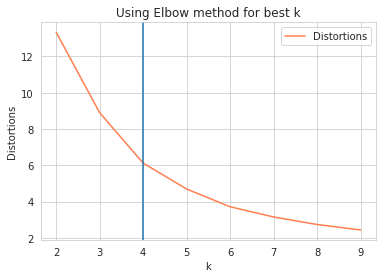

In [15]:
def best_kmeans_elbow(features, n_clusters, verbose=False, show=False):
  # list of clusters
  clusters = list(range(2, n_clusters))
  # store all distortions
  distortions = []
  # apply kmeans for each cluster values
  for n_clusters in clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(features)
    # get distortions
    distortion = kmean_model.inertia_
    distortions.append(distortion)
    # print output
    if verbose: print("For n_clusters =", n_clusters, "Distortion is :", distortion)
  # locate knee
  kn = KneeLocator(clusters, distortions, curve='convex', direction='decreasing')
  best_k = int(kn.knee)
  # plot
  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      distortions,
                      color="coral", 
                      label="Distortions")
  plot.set(xlabel='k', ylabel='Distortions')
  plot.set_title('Using Elbow method for best k')
  plot.axvline(x=best_k)
  if show: plt.show()
  fig = plot.get_figure()
#   fig.savefig("elbow_distortions.png")
  return

# run function
best_kmeans_elbow(features=reviews_embeddings, 
                  n_clusters=max_n_cluster, 
                  verbose=True)

## Silhouette Method [time consuming]

* The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. More info [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html)

For n_clusters = 2 The average silhouette_score is : 0.50652504
For n_clusters = 3 The average silhouette_score is : 0.43563285
For n_clusters = 4 The average silhouette_score is : 0.46562195
For n_clusters = 5 The average silhouette_score is : 0.43318874
For n_clusters = 6 The average silhouette_score is : 0.42494044
For n_clusters = 7 The average silhouette_score is : 0.4020386
For n_clusters = 8 The average silhouette_score is : 0.39321813
For n_clusters = 9 The average silhouette_score is : 0.37653


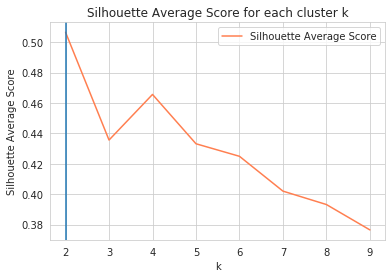

In [16]:
def best_kmeans_silhouette(features, n_clusters):
  # get list of clusters  
  clusters = list(range(2, n_clusters))
  # store all silhouttes values
  silhouettes = []
  # run k-means for each cluter
  for n_clusters in clusters:
    # Initialize the clusterer with n_clusters value and a random generator
    kmean_model = KMeans(n_clusters=n_clusters)
    kmean_model.fit(np.array(features))
    # get labels predicted
    cluster_labels = kmean_model.predict(features)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(features, cluster_labels)
    silhouettes.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
  # find best k
  best_k = clusters[silhouettes.index(max(silhouettes))]
  # plot
  sns.set_style("whitegrid")
  plot = sns.lineplot(clusters, 
                      silhouettes,
                      color="coral", 
                      label="Silhouette Average Score")
  plot.set(xlabel='k', ylabel='Silhouette Average Score')
  plot.set_title('Silhouette Average Score for each cluster k')
  plot.axvline(x=best_k)
  fig = plot.get_figure()
#   fig.savefig("silhouette_avg.png")
  return

# run fucntion
best_kmeans_silhouette(features=reviews_embeddings, 
                       n_clusters=max_n_cluster)

# Run Best k-means model

In [17]:
# pick best k based on previous experiments
best_k = 2
# build model using specific k
kmean_model = KMeans(n_clusters=best_k)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
best_kmeans_labels = kmean_model.labels_

## PCA Visualize

In [18]:
def pca_reduction(features, labels_values, n_components, random_state=20, 
                  label_decoder=None, title='PCA Plot', magnify=2):
  pca_cuml = PCA(n_components=n_components,
                   random_state=random_state)
  reduced_features = pca_cuml.fit_transform(features)

  # plot
  if (n_components==2) and (labels_values is not None):
    # create data frame
    reduced_features_df = pd.DataFrame()
    reduced_features_df['x'] = [float(value) for value in reduced_features[:,0]]
    reduced_features_df['y'] = [float(value) for value in reduced_features[:,1]]
    if label_decoder is not None:
      reduced_features_df['clusters'] = [label_decoder[int(value)] for value in labels_values]
    else:
      reduced_features_df['clusters'] = [int(value) for value in labels_values]
    #plot data with seaborn
    cluster_plot = sns.lmplot(data=reduced_features_df, x='x', y='y', hue='clusters', fit_reg=False, legend=True, legend_out=True)
    plt.title(title)
    fig = plt.gcf()
    figsize = fig.get_size_inches()
    fig.set_size_inches(figsize * magnify)
    plt.show()
#     cluster_plot.savefig("pca_plot.png")
  return reduced_features

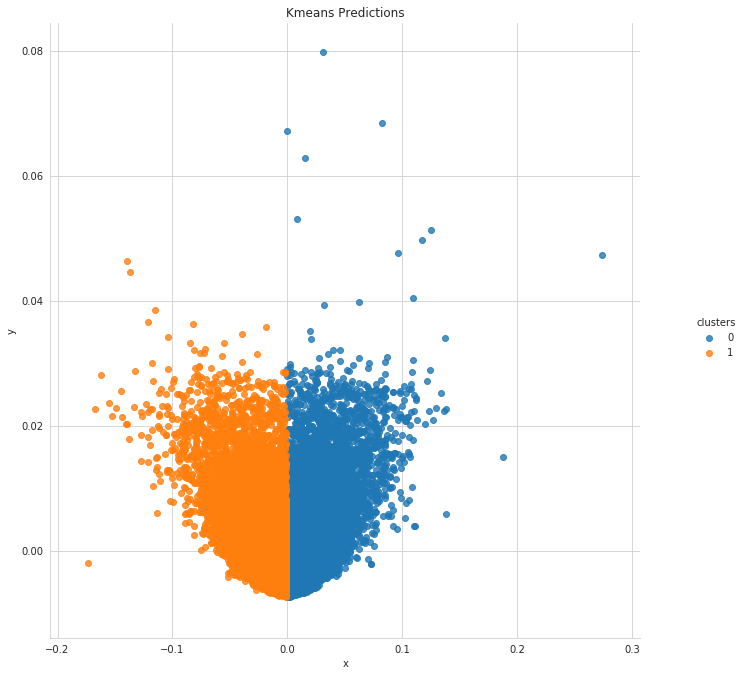

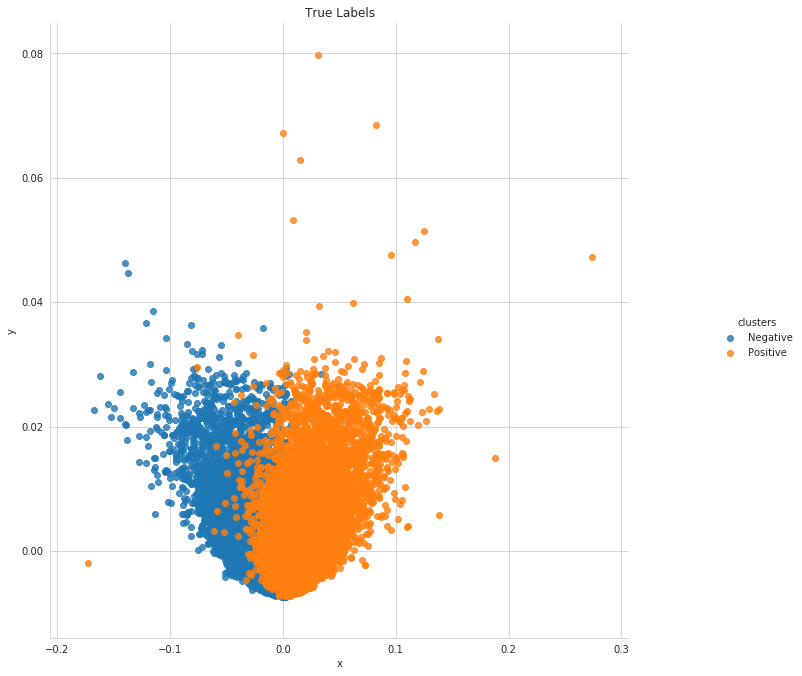



Found labels: [0, 1]



labels                  cluster_match
0  0       Positive:22890  Negative:3080
1  1       Negative:21920  Positive:2110

In [19]:
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=best_kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=None,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=reviews_embeddings, 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')

print('\n')
matching_df = predictions_overlap(model_predicitons=best_kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

# K Means Sentiments

## k=3 sentiments

In [20]:
k_sentiments = 3
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [21]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2]



labels                   cluster_match
0  0       Negative:10064  Positive:192  
1  1       Positive:14720  Negative:404  
2  2       Negative:14532  Positive:10088

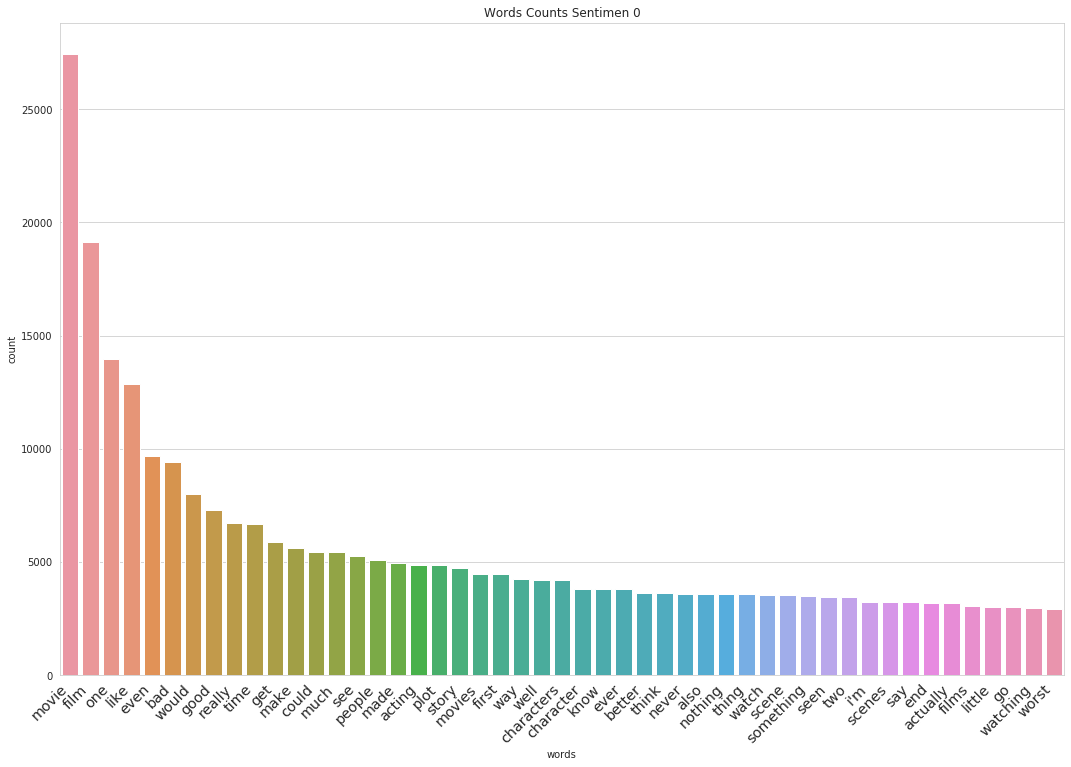

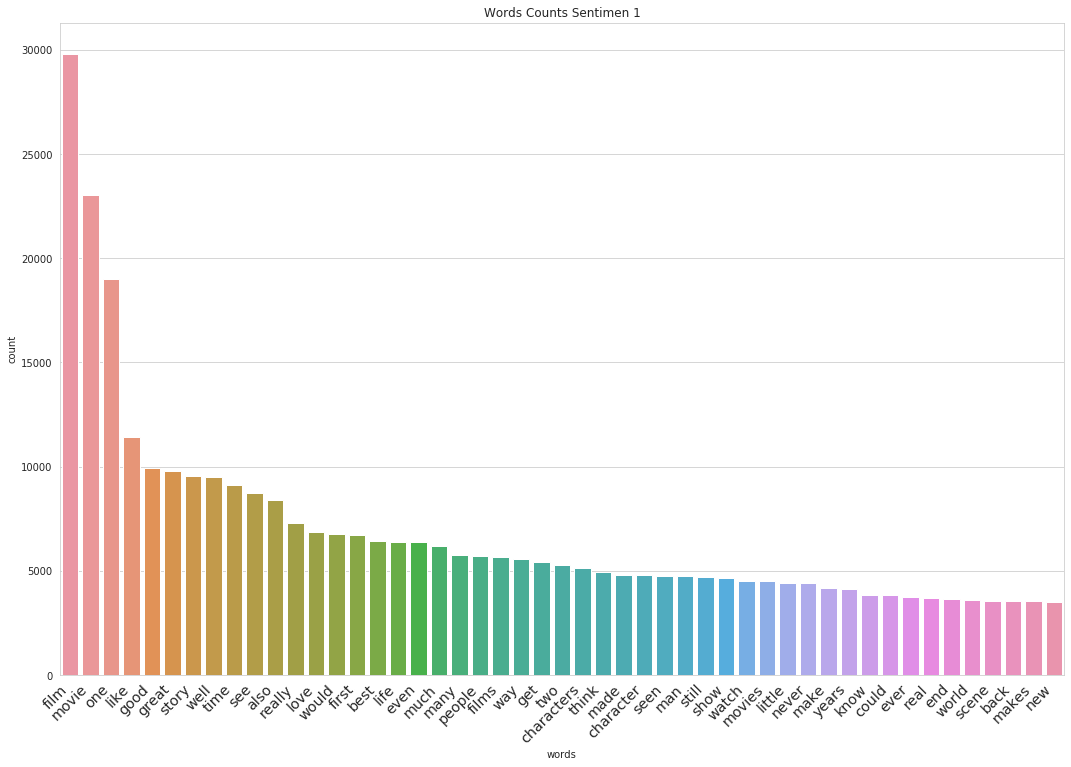

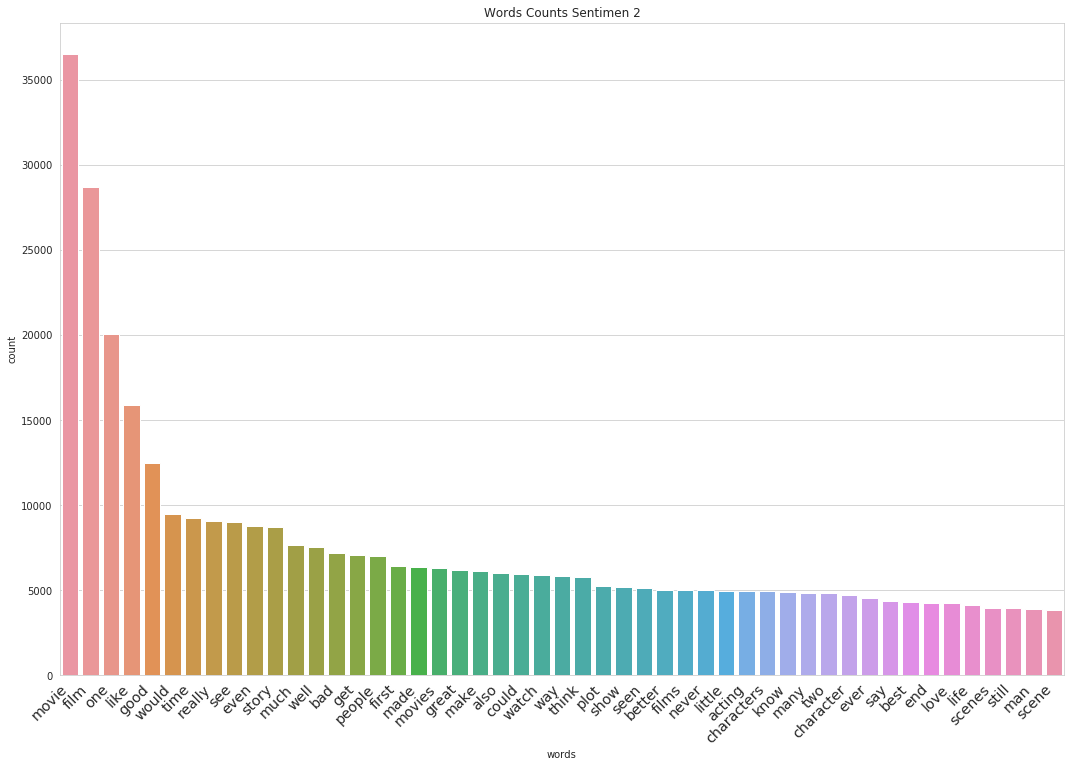

In [24]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), #None, #stopwords.words('english'), 
                    magnify=3)

### Visualize

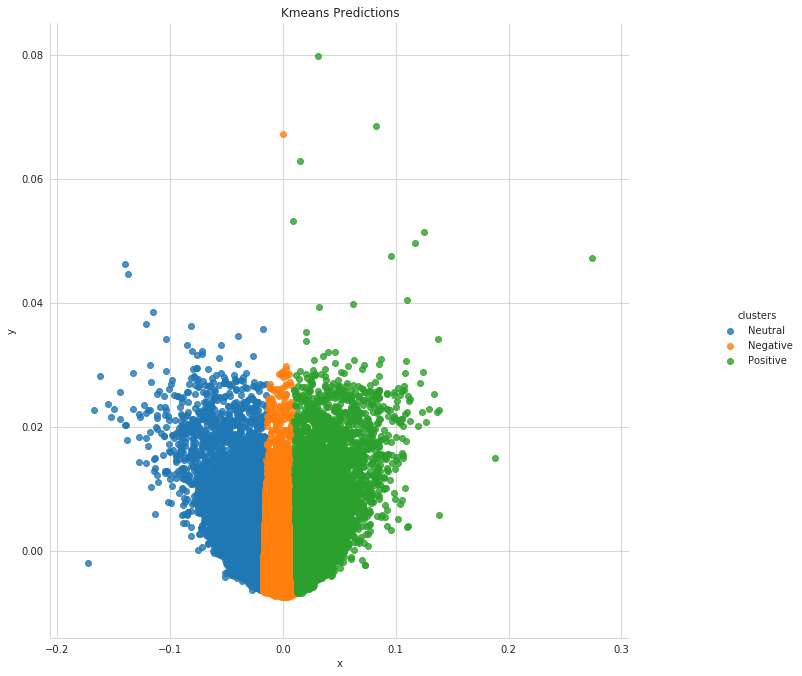

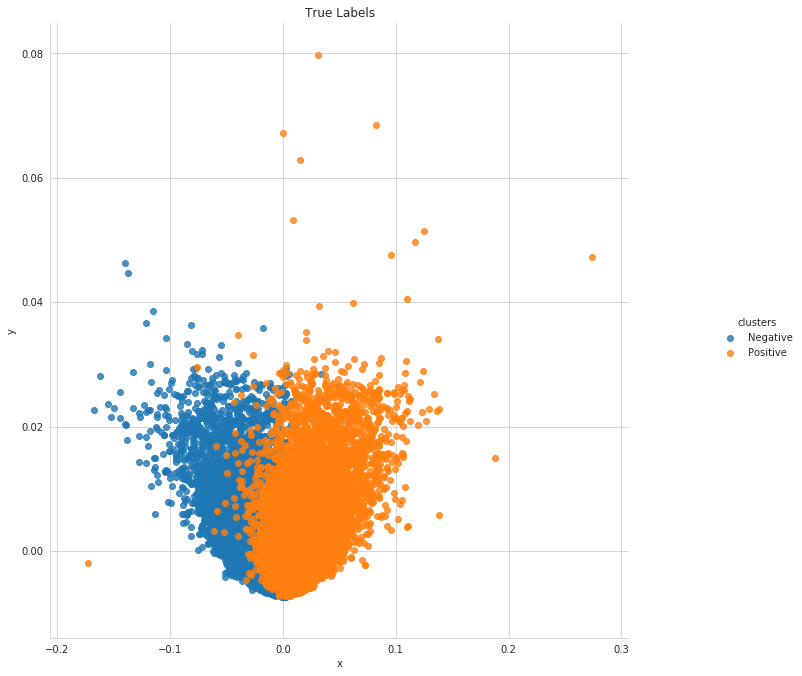

In [25]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [26]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                          trues=reviews_sentiments, 
                          trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                          predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  \
0  For a good half hour or so, I remember myself thinking: "Hey, this could very well be Bill Rebane's best achievement ever!". The opening sequences are atmospheric, there immediately are some scary moments to enjoy and our director even refers to his own notorious stinker "The Giant Spider Invasion" in a playful way. The concept is shamelessly stolen from William Castle's "House on Haunted Hill", with three old and extremely bored millionaires luring nine losers to an isolated mansion to win $1,000,000 in an elimination game. Naturally, the participants start vanishing quickly and one by one, and it takes the remaining greedy boneheads too much time before they realize either the old folks are sadists...or there's another murderer amongst them. The film begins & ends with an odd narrator telling a lot of senseless stuff that isn't relevant or even interesting to the plot, but there's some nice T&A to admire in the first ten minutes and that dumb bimbo (Shelly, I believe she's called) is really hilarious to observe. After the first half hour, naturally the inevitable happens and "The Cold" turns into a textbook Rebane-production with retarded plot twists, the dumbest dialogs ever and a total lack of excitement. There wasn't any budget for bloody murder sequences but our multi-talented director (?) tries to compensate this with endless footage of disco dancing girls and an amateur rock band. The film also has four or even five different climaxes and none of them are a slight bit satisfying. Maybe it was an inspiration for LOTR: Return of the King? Avoid this film, you'll live longer and happier.   
1  As a sci-fi and casual Angelina Jolie fan, I thought this obviously low-budget movie might be worth a look... maybe it had a few scenes or a storyline that would make up for all its other faults. Plus, it might be interesting to watch Angelina as she was embarking on her star-bound career.<br /><br />Oh how wrong I was. One thing I learned -- at 18, Angelina Jolie couldn't act. So, to make her comfortable, the producers cast this entire movie with people who couldn't act. Seeing this, Jack Palance (who can actually act) decided to overact. Watching 10 minutes of this happen is enough to burn your eyes out.<br /><br />To the horrible acting and overacting add a nonsensical script, insipid dialog, bottom-of-the-barrel cinematography... in fact add bottom-of-the-barrel everything.<br /><br />The story features Angelina as a cyborg programmed by her corporate overlords as an assassin. She escapes the corporate HQ with the help of her combat instructor. The corporation sends bounty hunters after them. Stupid stuff happens. The end. I would tell you more but I didn't want to waste my life watching this dreck.<br /><br />I implore you -- this is not worth watching. Its not even worth thinking about watching. Save yourself the pain and move on.                                                                                                                                                                                                                                                                                                                                                                              
2  Okay at first this movie seemed pretty good even though it was moving rather quick and even though they only had a $60,000 budget it was good but if you found your sister dead in a lake and found out who might have killed her why would you go chase him around and pull a gun on him with only one bullet and waste it and end up running from him all retarded and get yourself killed? Plus after you found your sister dead in the lake and found a clue and figured out who the killer was why wouldn't you hand that clue over to the police who think you killed her? And at the end of the movie when she acts like her sister who was a waitress and she is talking to the bad guy she should of met him somewhere and recorded him saying she was d

## k=4 sentiments

In [27]:
k_sentiments = 4
# build model using specific k
kmean_model = KMeans(n_clusters=k_sentiments)
# fit model to data
kmean_model.fit(reviews_embeddings)
# get predicted labels
kmeans_labels = kmean_model.labels_

### Find Labels

In [28]:
matching_df = predictions_overlap(model_predicitons=kmeans_labels, 
                                  true_predicitons=reviews_sentiments,
                                  label_decoder=ID_SENTIMENT)
matching_df.head()

Found labels: [0, 1, 2, 3]



labels                  cluster_match
0  0       Negative:4686  Positive:61   
1  1       Positive:17640  Negative:2894
2  2       Negative:17370  Positive:2151
3  3       Positive:5148  Negative:50

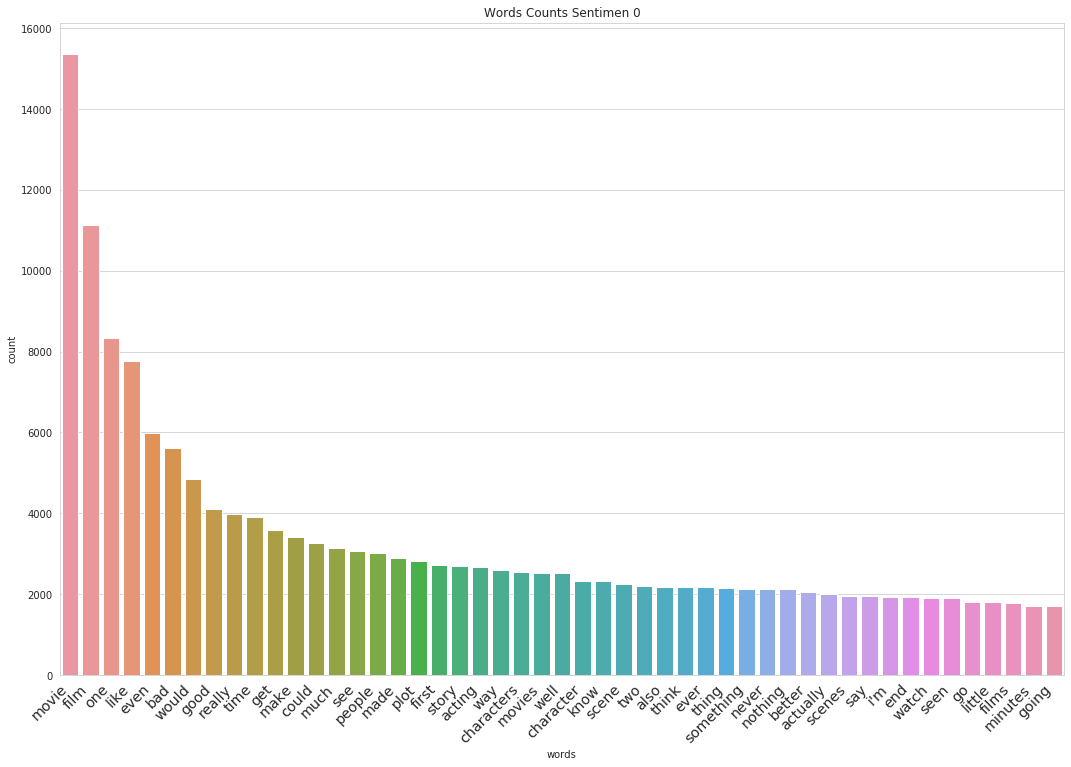

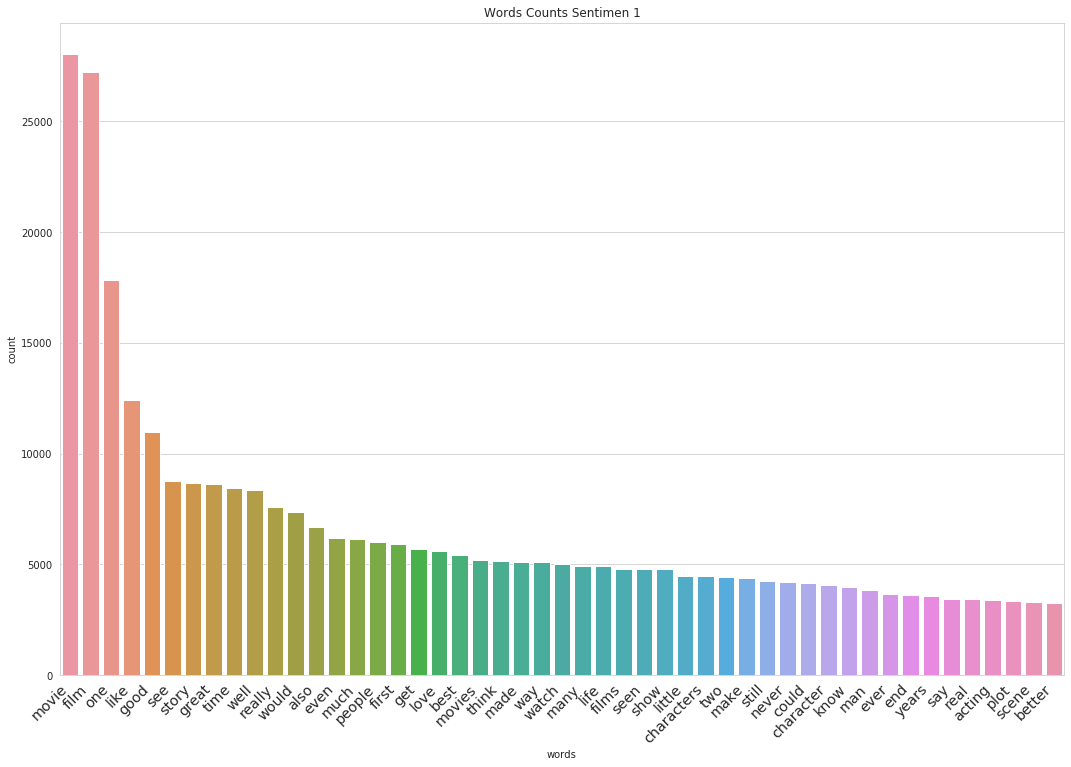

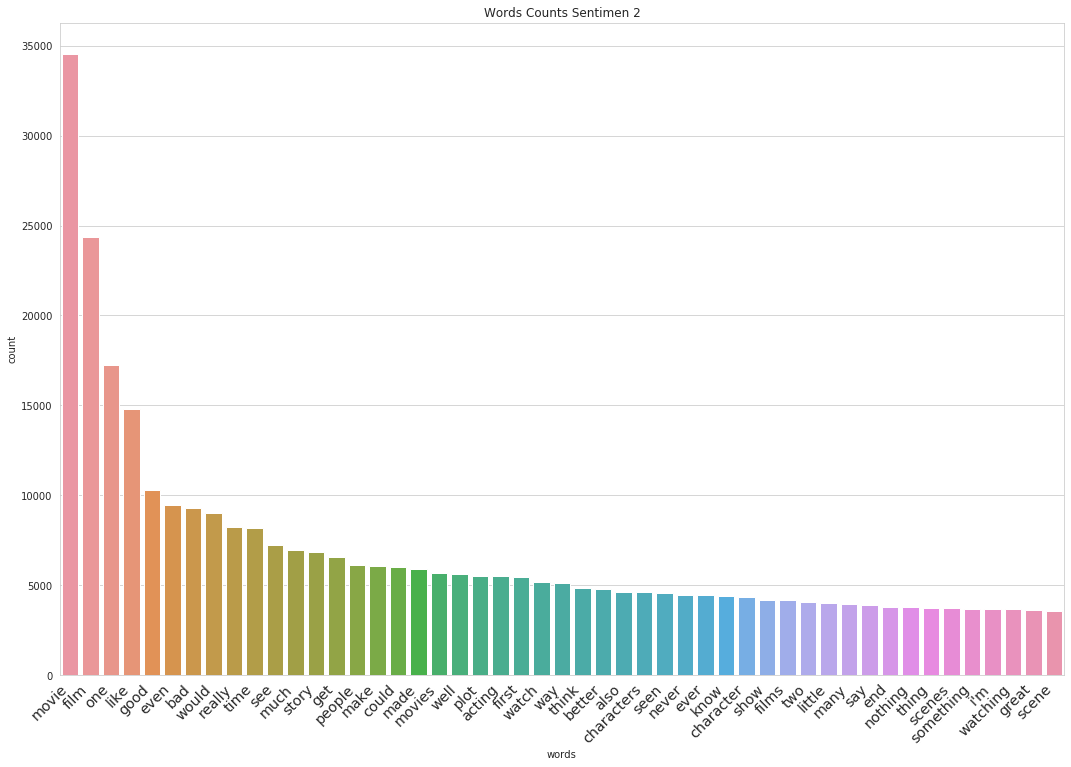

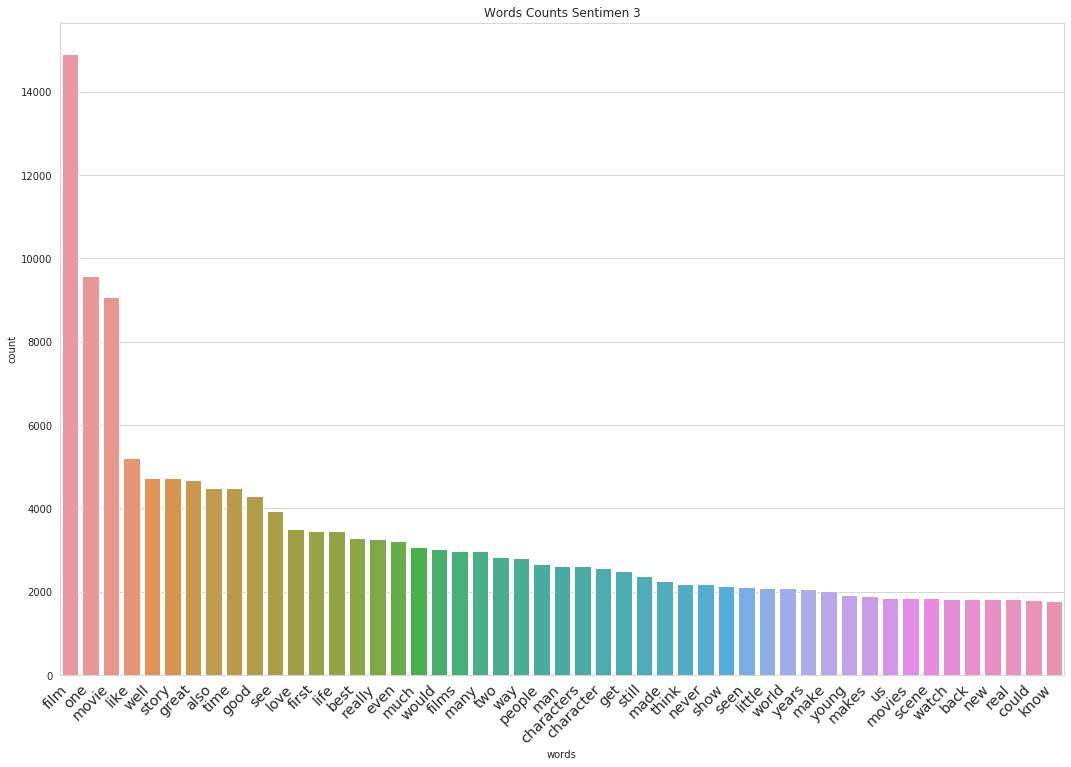

In [29]:
clusters_words_plot(texts=reviews_texts, 
                    labels=kmeans_labels, 
                    n_sentiments=k_sentiments, 
                    pos_tag=None,
                    top_clip=1,
                    low_clip=50,
                    stop_words=stopwords.words('english'), #None, #stopwords.words('english'), 
                    magnify=3)

### Visualize

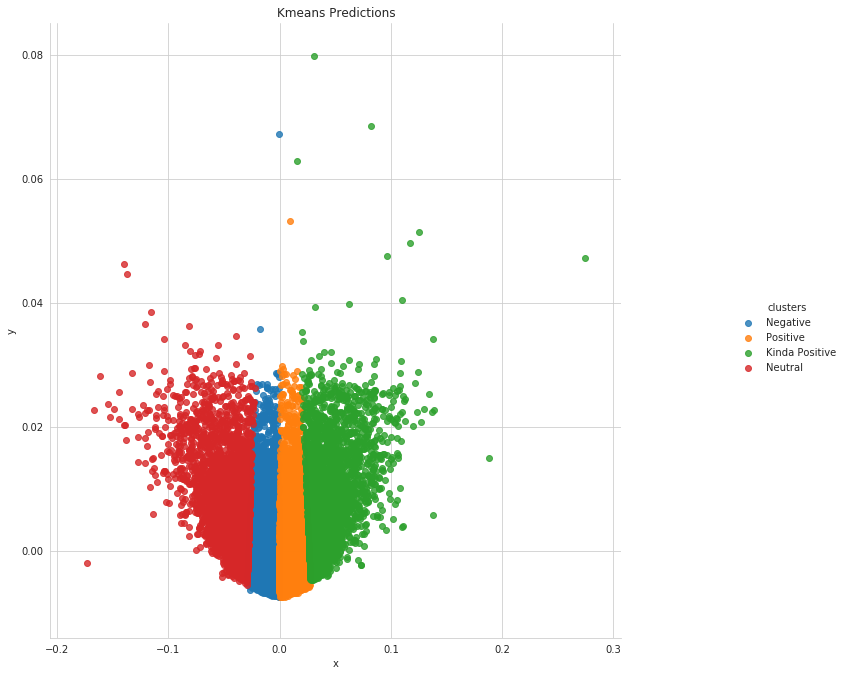

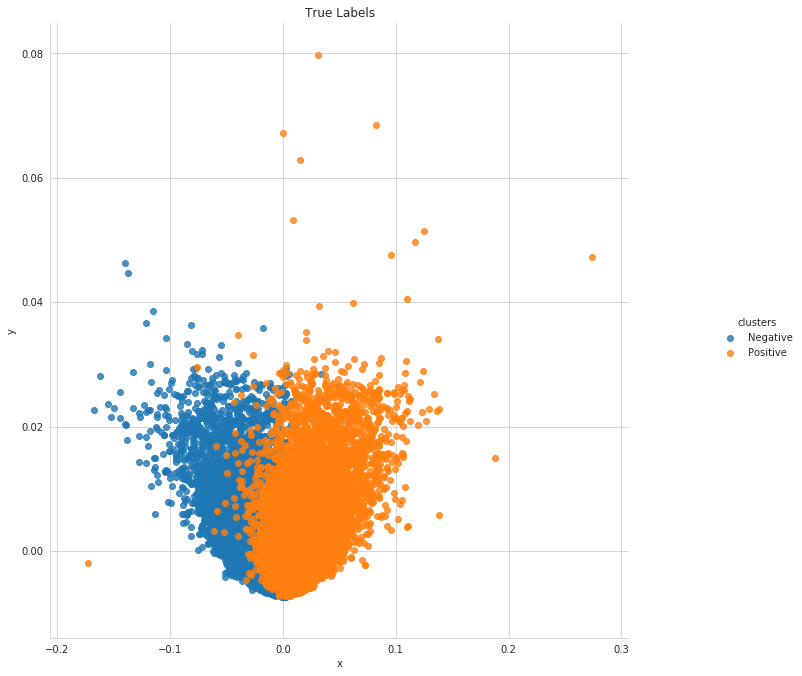

In [30]:
kmeans_id_sentiment = {0:'Neutral',
                        1:'Positive',
                        2:'Negative',
                       3:'Kinda Positive'}

reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=kmeans_labels, 
                                 n_components=2, 
                                 label_decoder=kmeans_id_sentiment,
                                 title='Kmeans Predictions')
print('\n')
reduced_features = pca_reduction(features=np.array(reviews_embeddings), 
                                 labels_values=reviews_sentiments, 
                                 n_components=2, 
                                 label_decoder=ID_SENTIMENT,
                                 title='True Labels')


### Samples

In [31]:
samples_df = show_samples(target_predicitons_class=0, 
                          texts=reviews_texts,
                        trues=reviews_sentiments, 
                        trues_id_sentiment=ID_SENTIMENT,
                          predicitons=kmeans_labels,
                        predictions_id_sentiment=kmeans_id_sentiment,
                          n_samples=3)
samples_df

Text  \
0  "Shade" tries hard to be another "Sting", substituting poker for horse racing as the means by which to bring down an enemy, but it fails miserably.<br /><br />I watched the whole thing and still never could quite understand why the young kid wanted to double-cross his partner. Was it because his partner stole his girl? Is there a woman in the world who is worth going to that much trouble over? If there is, it certainly wasn't this shrew. She had no redeeming qualities whatsoever, and really now, did she actually have a special room set up so that a surgeon could remove the kidney from whoever tried to pick her up in a bar? Dina Merrill makes a short appearance as a rich woman who hosts, of all things, pay-the-rent poker parties at her palatial home. And then the players say things like, "I'll see your thousand and raise you another five thousand." Give me a break. You can't call ("see") and raise, you do one or the other. Any kid playing for nickels and dimes at the kitchen table knows this; you'd think grown men playing for stakes this high -- or at least the knuckleheads who wrote the script -- would know it too.<br /><br />One of the other posters mentioned how no high-limit poker game would allow players to actually deal their own cards and I agree. You don't allow two of the best-known car cheats into a game where the buy-in is $250,000 and then let them deal to each other. That's not poker; that's just seeing which one can cheat better. And I'd like to know what person in his right mind would buy in to a game in which two of the best-known card cheats are playing and expect that he might have a chance at winning? And most of all, what Mafia boss would run such a game? Every time Melanie Griffith came on the screen I was so mesmerized by those gigantic fluorescent red lips of hers that I completely lost the storyline, and seeing her and Stallone together was more like a public service announcement for plastic surgery gone wrong than a love connection. Stallone mentions that she used to be a grifter before she bought the restaurant she now runs, but we don't know what kind of grifter she was and we never see her working with Stallone in their younger days so we are left to wonder, if we even care that much.<br /><br />Jamie Foxx is the best character in the whole movie, but he gets killed off right off the bat and we're left with cardboard cut-outs who all sound like they're reading their lines off a teleprompter just off-camera.<br /><br />The ending makes no sense either. The kid gets his cut from the game and just walks down the street with a briefcase full of money and his partner is nowhere to be seen? The Mafia isn't watching every move he makes? Everyone else just shrugs their shoulders and quietly accepts the loss of millions of dollars without trying to recoup any of it? I don't think so.<br /><br />Most of all, this movie does a great injustice to professional poker players all over the world, insinuating that the only way to win is by palming cards and playing with "juiced" decks. And why is it they're always palming kings and aces? Sometimes you need a three or a nine to fill a straight or full house.<br /><br />The best parts of the whole film are the sleight-of-hand tricks during the beginning and ending credits; everything in between is ridiculous.   
1  Now here is a film that if made in Australia would have easily been a comedy. Sadly and annoyingly, here it is, flaccid and cheesy and overbaked from Lala land. How did the di-erector get it so wrong? Well, mainly by being serious about a job so hilariously startling that nobody in their right mind could take seriously. Unless of course they were a nerdy lonely gay cliché (but somehow cute)...or is that cliché piled upon cliché. No value in the story that almost seems like a prequel to Gus Van Sant's GERRY..... and with a title like THE FLUFFER how is it all such a lead weight? Well this auteur must have soooooo mad that he didn't get to Burt and 

# Custom Samples

In [32]:
custom_text = "This workshop roks!!"

encoding = text_features.encode(custom_text)
encoding = tf.keras.preprocessing.sequence.pad_sequences(sequences=[encoding], 
                                                       maxlen=MAX_LEN, 
                                                       dtype='int64', 
                                                       padding='post', 
                                                       truncating='post', 
                                                       value=0)
embedding = embedding_model(encoding)
kmean_label = kmean_model.predict(tf.get_static_value(embedding))[0]

print('Text: ',custom_text)
print('Sentiment: ', kmeans_id_sentiment[kmean_label])

Text:  This workshop roks!!
Sentiment:  Positive
